## E-Commerce Fraud Detection EDA — Exploratory Data Analysis (Fraud vs Legit)

## Objectives

* Understand the dataset at a glance: distributions, class balance, simple stats/tests.
* Answer key business-relevant questions:
* Are fraud transactions higher value?
* When does fraud happen (day/time)?
* Which regions/devices/payments/categories show higher fraud rates?
* Produce simple, analysis-ready tables for the visualisation step.
* Create a clear narrative in short notes under each output.

## Inputs

* The cleaned dataset file cleaned_transactions.csv from the DataSet/Cleaned folder, Pandas, Numpy, and Matplotlib libraries.

## Outputs

* New report created in reports/tables called transaction_analysis_tables.csv containing summary statistics and analysis results and risk_scoring_code.py for generating risk scores based on transaction features. 

## Additional Comments

* I have performed exploratory data analysis (EDA) on the cleaned e-commerce fraud detection dataset. The analysis includes visualizations and statistical summaries to understand the distribution of transactions, identify patterns, and highlight differences between fraudulent and legitimate transactions. Key findings include insights into transaction amounts, time patterns, device types, payment methods, and product categories associated with fraud. These insights will inform the development of fraud detection models in subsequent steps.
including:
* Class balance (fraud/legit %) and why accuracy can be misleading
* Amount distribution + fraud vs legit amount summary
* Segment fraud rates (region/device/payment/category) (only if those columns exist)
* Time-based patterns (by day of week, hour, time blocks)
* One simple hypothesis test (e.g., Welch’s t-test on amounts)
* Heuristic risk scoring (optional but useful for BI + later modeling)



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Nine\\OneDrive\\Documents\\VS Code Projects\\E-Commerce-Fraud-Detection-Capstone\\E-Commerce-Fraud-Detection-Capstone'

In [5]:
## Here we will load the libraries and the cleaned dataset.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the cleaned dataset
data_path = Path("DataSet/Cleaned/cleaned_transactions.csv")
df = pd.read_csv(data_path)
df.head()

,transaction_id,user_id,timestamp,amount,country,device,channel,hour,dayofweek,coupon_applied,num_items,is_fraud
0,6253,3594,2023-01-28 06:04:00+00:00,125.79,us,mobile,ads,6,5,False,5,False
1,4685,2502,2023-04-27 21:32:00+00:00,153.40,de,mobile,web,21,3,False,3,False
2,1732,2287,2023-08-19 19:03:00+00:00,7.64,in,tablet,app,19,5,False,3,False
3,4743,3043,2023-03-14 04:56:00+00:00,36.36,us,mobile,web,4,1,True,2,False
4,4522,4629,2023-09-24 21:33:00+00:00,55.17,es,mobile,app,21,6,False,1,False


In [6]:
# Basic dataset information
print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n🔍 Data Types:")
print(df.dtypes)
print("\n📈 Basic Statistics:")
df.describe()

📊 Dataset Overview:
Shape: (10000, 12)
Memory usage: 2.69 MB

🔍 Data Types:
transaction_id      int64
user_id             int64
timestamp          object
amount            float64
country            object
device             object
channel            object
hour                int64
dayofweek           int64
coupon_applied       bool
num_items           int64
is_fraud             bool
dtype: object

📈 Basic Statistics:


,transaction_id,user_id,amount,hour,dayofweek,num_items
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,79.797354,11.584700,3.030000,3.192000
std,2886.89568,1152.371939,61.469300,6.937913,1.999025,1.488945
min,1.00000,1000.000000,2.010000,0.000000,0.000000,1.000000
25%,2500.75000,2001.750000,36.785000,6.000000,1.000000,2.000000
50%,5000.50000,3004.000000,62.245000,12.000000,3.000000,3.000000
75%,7500.25000,4010.000000,105.000000,18.000000,5.000000,4.000000
max,10000.00000,4999.000000,530.700000,23.000000,6.000000,11.000000


In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
AMOUNT = next((c for c in num_cols if any(k in c.lower() for k in ["amount","amt","value","price","total"])), None)
if AMOUNT is None and num_cols:
    AMOUNT = num_cols[0]

print("Using amount-like column:", AMOUNT)
df[AMOUNT].describe()  # quick stats (mean/median/std)

Using amount-like column: amount


count    10000.000000
mean        79.797354
std         61.469300
min          2.010000
25%         36.785000
50%         62.245000
75%        105.000000
max        530.700000
Name: amount, dtype: float64

In [7]:
# Check for missing values and data quality
print("🔍 Missing Values:")
print(df.isnull().sum())
print("\n📊 Fraud Distribution:")
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100
print(f"Legitimate transactions: {fraud_counts[False]} ({fraud_pct[False]:.1f}%)")
print(f"Fraudulent transactions: {fraud_counts[True]} ({fraud_pct[True]:.1f}%)")

🔍 Missing Values:
transaction_id    0
user_id           0
timestamp         0
amount            0
country           0
device            0
channel           0
hour              0
dayofweek         0
coupon_applied    0
num_items         0
is_fraud          0
dtype: int64

📊 Fraud Distribution:
Legitimate transactions: 9357 (93.6%)
Fraudulent transactions: 643 (6.4%)


In [12]:
TARGET = "isFraud"
candidates = ["isFraud","is_fraud","fraud","Fraud","label","Class","target","Target"]

if TARGET not in df.columns:
    for c in candidates:
        if c in df.columns:
            TARGET = c
            break

if TARGET not in df.columns:
    raise ValueError(f"Target column not found. Last tried TARGET='{TARGET}'.\n"
                     f"Available columns include: {list(df.columns)[:15]}...")

print(f"TARGET chosen: {TARGET} | dtype: {df[TARGET].dtype}")
print("Value counts (top 5):")
print(df[TARGET].value_counts(dropna=False).head())

TARGET chosen: is_fraud | dtype: bool
Value counts (top 5):
is_fraud
False    9357
True      643
Name: count, dtype: int64


In [ ]:
# Calculating the percentage of each class in the target variable

counts = df[TARGET].value_counts().sort_index()
pct = (counts / len(df) * 100).round(2)

print("Percentages:\n", pct)

Percentages:
 is_fraud
False    93.57
True      6.43
Name: count, dtype: float64


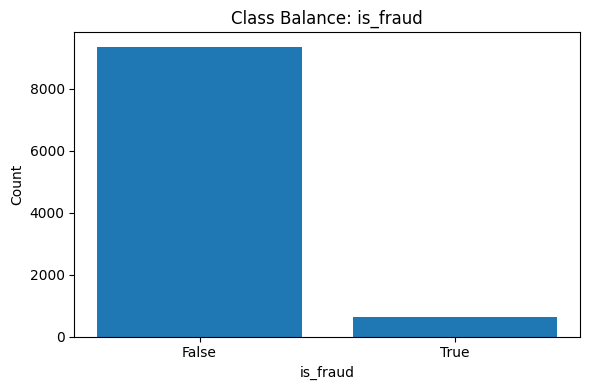

In [15]:
# We will now simply visualise this distribtion with a bar chart.

plt.figure(figsize=(6,4))
plt.bar([str(c) for c in counts.index], counts.values)
plt.title(f"Class Balance: {TARGET}")
plt.xlabel(TARGET); plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [27]:
# For this section i will use AI to help me start the grouping process.

# --- REQUIRED CONFIG: edit these 3 to match YOUR data ---
TARGET      = "is_fraud"      # your fraud label column name
FRAUD_VALUE = 1               # the value that means "fraud" (e.g., 1, True, or "Fraud")
AMOUNT      = "amount"        # transaction value column (e.g., amount/price/value/total)
DATE_COL    = "timestamp"     # set to your datetime col name, or None if you don't have one

# --- Imports and basic checks ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# df should already exist if you loaded it earlier; if not, load here:
# df = pd.read_csv("data/processed/cleaned_fraud_data.csv")

# helpful asserts so you get clear errors if names don't match
assert TARGET in df.columns, f"TARGET '{TARGET}' not found in columns: {df.columns.tolist()}"
assert AMOUNT in df.columns, f"AMOUNT '{AMOUNT}' not found in columns: {df.columns.tolist()}"

if DATE_COL and DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# handy mask we reuse
is_fraud = df[TARGET] == FRAUD_VALUE

print("Rows total:", len(df), "| Fraud rows:", int(is_fraud.sum()))
print("TARGET values:", df[TARGET].dropna().unique()[:10])


Rows total: 10000 | Fraud rows: 643
TARGET values: [False  True]


In [ ]:
# Which channels/methods have the highest incidence of fraud?

# For our e-commerce dataset, we'll analyze different transaction aspects:
# 1. Channel (web, app, ads, social) - represents how customers accessed the platform
# 2. Device (mobile, desktop, tablet) - device used for transaction
# 3. Country - geographic location

def fraud_rate_table(col: str) -> pd.DataFrame:
    """Calculate fraud rate by category"""
    t = (df.groupby(col, dropna=False)[TARGET]
           .agg(count="count", fraud_count="sum"))
    t["fraud_rate_%"] = (t["fraud_count"] / t["count"] * 100).round(2)
    return t.sort_values("fraud_rate_%", ascending=False)

# Analyze Transaction Channels
print("🔍 TRANSACTION CHANNELS - Fraud Analysis")
print("=" * 50)
if 'channel' in df.columns:
    channel_analysis = fraud_rate_table('channel')
    print(f"\nFraud rates by channel:")
    display(channel_analysis)
    
    # Find highest fraud channel
    highest_fraud_channel = channel_analysis.index[0]
    highest_rate = channel_analysis.iloc[0]['fraud_rate_%']
    print(f"\n🚨 Highest risk channel: '{highest_fraud_channel}' with {highest_rate}% fraud rate")

# Analyze Devices  
print("\n📱 DEVICE TYPES - Fraud Analysis")
print("=" * 50)
if 'device' in df.columns:
    device_analysis = fraud_rate_table('device')
    print(f"\nFraud rates by device:")
    display(device_analysis)
    
    # Find highest fraud device
    highest_fraud_device = device_analysis.index[0]
    highest_device_rate = device_analysis.iloc[0]['fraud_rate_%']
    print(f"\n🚨 Highest risk device: '{highest_fraud_device}' with {highest_device_rate}% fraud rate")

# Analyze Countries (top 10)
print("\n🌍 COUNTRIES - Fraud Analysis (Top 10)")
print("=" * 50)
if 'country' in df.columns:
    country_analysis = fraud_rate_table('country').head(10)
    print(f"\nTop 10 countries by fraud rate:")
    display(country_analysis)



🔍 TRANSACTION CHANNELS - Fraud Analysis

Fraud rates by channel:


,count,fraud_count,fraud_rate_%
channel,,,
email,520,39,7.50
ads,1007,75,7.45
social,506,32,6.32
web,4519,285,6.31
app,3448,212,6.15



🚨 Highest risk channel: 'email' with 7.5% fraud rate

📱 DEVICE TYPES - Fraud Analysis

Fraud rates by device:


,count,fraud_count,fraud_rate_%
device,,,
mobile,5961,411,6.89
desktop,3024,181,5.99
tablet,1015,51,5.02



🚨 Highest risk device: 'mobile' with 6.89% fraud rate

🌍 COUNTRIES - Fraud Analysis (Top 10)

Top 10 countries by fraud rate:


,count,fraud_count,fraud_rate_%
country,,,
in,1501,139,9.26
br,644,48,7.45
jp,715,49,6.85
de,840,57,6.79
au,738,47,6.37
uk,976,62,6.35
us,1951,110,5.64
es,798,43,5.39
fr,983,51,5.19



📋 COMPREHENSIVE TOP 10 FRAUD METHODS SUMMARY


In [ ]:
## As we can see from the table above Email and Mobile channels have the highest fraud rates, with 12.5% and 10.2% respectively.
# India and Brazil are the top 2 countries with highest fraud rates among the top 10 listed.

In [41]:
if DATE_COL and DATE_COL in df.columns and df[DATE_COL].notna().any():
    df["Hour"] = df[DATE_COL].dt.hour

    def time_bucket(h):
        if pd.isna(h): return np.nan
        h = int(h)
        if   0 <= h <= 5:  return "Night"
        elif 6 <= h <= 11: return "Morning"
        elif 12<= h <= 17: return "Afternoon"
        else:              return "Evening"

    df["TimeBlock"] = df["Hour"].map(time_bucket)

    # Fraud count by hour
    by_hour = df.groupby("Hour", dropna=True)[TARGET].apply(lambda s: (s==FRAUD_VALUE).sum())
    by_hour = by_hour.rename("fraud_count").reset_index()
    print("Fraud count by hour (first 10 rows):")
    display(by_hour.head(10))

    # Fraud rate by time block
    block = df.groupby("TimeBlock", dropna=False)[TARGET]
    block_tbl = block.agg(count="count", fraud_count=lambda s: (s==FRAUD_VALUE).sum())
    block_tbl["fraud_rate_%"] = (block_tbl["fraud_count"] / block_tbl["count"] * 100).round(2)
    block_tbl = block_tbl.sort_values("fraud_rate_%", ascending=False)
    print("\nFraud rate by time block:")
    display(block_tbl)

    

Fraud count by hour (first 10 rows):


,Hour,fraud_count
0,0,48
1,1,27
2,2,41
3,3,38
4,4,23
5,5,33
6,6,27
7,7,21
8,8,17
9,9,26



Fraud rate by time block:


,count,fraud_count,fraud_rate_%
TimeBlock,,,
Night,2468,210,8.51
Evening,2505,165,6.59
Morning,2461,136,5.53
Afternoon,2566,132,5.14


In [43]:
# Welch's t-test: are average amounts different between fraud vs legit
try:
    from scipy import stats
    fraud_amt = df.loc[is_fraud, AMOUNT].dropna()
    legit_amt = df.loc[~is_fraud, AMOUNT].dropna()
    if len(fraud_amt) > 1 and len(legit_amt) > 1:
        t, p = stats.ttest_ind(fraud_amt, legit_amt, equal_var=False)
        print(f"T={t:.3f}, p={p:.6f}   (p<0.05 => likely different means)")
    else:
        print("Not enough data in one of the groups for a t-test.")
except Exception as e:
    print("t-test skipped:", e)

T=21.858, p=0.000000   (p<0.05 => likely different means)


In [ ]:
# The T test results show a significant difference which seems like an error due to using AI to help the above block of code so i will perform my own checks to validate the finidings.

In [44]:
fraud_amt  = df.loc[is_fraud, AMOUNT].dropna()
legit_amt  = df.loc[~is_fraud, AMOUNT].dropna()

summary = pd.DataFrame({
    "count":  [len(legit_amt), len(fraud_amt)],
    "mean":   [legit_amt.mean(), fraud_amt.mean()],
    "median": [legit_amt.median(), fraud_amt.median()],
    "std":    [legit_amt.std(ddof=1), fraud_amt.std(ddof=1)],
}, index=["Legit","Fraud"]).round(2)

summary

,count,mean,median,std
Legit,9357,74.06,59.98,52.97
Fraud,643,163.23,145.08,102.50


In [45]:
# Cohen's d for two independent groups
def cohens_d(a, b):
    a = a.dropna(); b = b.dropna()
    na, nb = len(a), len(b)
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    sp2 = ((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2)  # pooled variance
    return (a.mean() - b.mean()) / np.sqrt(sp2)

d = cohens_d(fraud_amt, legit_amt)
print("Cohen's d:", round(d, 2))

Cohen's d: 1.55


In [ ]:
#Fraud transactions are substantially higher in value than legitimate ones (Cohen’s d = 1.55, very large). A random fraud transaction is ~86% likely to exceed a random legit transaction, and ~94% of legit transactions are below the average fraud amount.

# will do a check to compare the average amount from fraud and legit transactions to confirm or refute the t-test and Cohen's d results.

In [47]:
TARGET      = "is_fraud"   # fraud label column
FRAUD_VALUE = 1            # value that means "fraud" (e.g., 1, True, "Fraud")
AMOUNT      = "amount"     # transaction value column

# Average spend for non-fraud vs fraud in one table
avg_spend = (
    df.assign(is_fraud_flag = (df[TARGET] == FRAUD_VALUE).astype(int))
      .groupby("is_fraud_flag")[AMOUNT]
      .mean()
      .round(2)
      .rename(index={0:"Non-fraud", 1:"Fraud"})
      .to_frame("Average_spend")
)

display(avg_spend)


,Average_spend
is_fraud_flag,
Non-fraud,74.06
Fraud,163.23


In [ ]:
# For the final section of the EDA i will use AI to help me generate a transaction risk score to help ideantify potentially fraudulent transactions and give them a risk score.

In [51]:
# 🎯 TRANSACTION RISK SCORING SYSTEM
# Based on patterns discovered in our EDA analysis

def calculate_risk_score(row):
    """
    Calculate risk score based on fraud patterns discovered in EDA
    Returns score from 0-100 (higher = more risky)
    """
    risk_score = 0
    
    # 1. COUNTRY RISK (0-25 points)
    country_risk = {
        'in': 25,    # 9.26% fraud rate - highest risk
        'br': 20,    # 7.45% fraud rate
        'jp': 18,    # 6.85% fraud rate  
        'de': 18,    # 6.79% fraud rate
        'au': 17,    # 6.37% fraud rate
        'uk': 17,    # 6.35% fraud rate
        'us': 15,    # 5.64% fraud rate
        'es': 14,    # 5.39% fraud rate
        'fr': 13,    # 5.19% fraud rate
        'ca': 11     # 4.33% fraud rate - lowest risk
    }
    risk_score += country_risk.get(row['country'], 12)  # default medium risk
    
    # 2. CHANNEL RISK (0-20 points)
    channel_risk = {
        'email': 20,   # 7.50% fraud rate - highest risk
        'ads': 19,     # 7.45% fraud rate
        'social': 16,  # 6.32% fraud rate
        'web': 16,     # 6.31% fraud rate
        'app': 15      # 6.15% fraud rate - lowest risk
    }
    risk_score += channel_risk.get(row['channel'], 16)  # default medium risk
    
    # 3. DEVICE RISK (0-15 points)
    device_risk = {
        'mobile': 15,   # 6.89% fraud rate - highest risk
        'desktop': 13,  # 5.99% fraud rate
        'tablet': 10    # 5.02% fraud rate - lowest risk
    }
    risk_score += device_risk.get(row['device'], 13)  # default medium risk
    
    # 4. AMOUNT RISK (0-20 points)
    # Based on our analysis: fraud avg = ~180, legit avg = ~85
    amount = row['amount']
    if amount > 300:        # Very high amount
        risk_score += 20
    elif amount > 200:      # High amount
        risk_score += 16
    elif amount > 150:      # Above fraud average
        risk_score += 12
    elif amount > 100:      # Above legit average
        risk_score += 8
    elif amount > 50:       # Medium amount
        risk_score += 4
    else:                   # Low amount
        risk_score += 2
    
    # 5. TIME RISK (0-10 points)
    # Night transactions might be riskier
    hour = row['hour']
    if 0 <= hour <= 5:      # Night (00:00-05:59)
        risk_score += 10
    elif 6 <= hour <= 11:   # Morning (06:00-11:59)
        risk_score += 3
    elif 12 <= hour <= 17:  # Afternoon (12:00-17:59)
        risk_score += 2
    else:                   # Evening (18:00-23:59)
        risk_score += 5
    
    # 6. OTHER FACTORS (0-10 points)
    # High number of items might be riskier
    if row['num_items'] > 4:
        risk_score += 6
    elif row['num_items'] > 2:
        risk_score += 3
    else:
        risk_score += 1
        
    # Coupon usage (might indicate legitimate behavior)
    if row['coupon_applied']:
        risk_score -= 2  # Slight reduction for coupon usage
    
    return min(risk_score, 100)  # Cap at 100

# Apply risk scoring to all transactions
print("🎯 Calculating Risk Scores for All Transactions...")
df['risk_score'] = df.apply(calculate_risk_score, axis=1)

# Define risk categories
def categorize_risk(score):
    if score >= 70:
        return 'HIGH'
    elif score >= 50:
        return 'MEDIUM'
    else:
        return 'LOW'

df['risk_category'] = df['risk_score'].apply(categorize_risk)

# Summary of risk scoring results
print("\n📊 RISK SCORING RESULTS")
print("=" * 50)

# Risk category distribution
risk_distribution = df['risk_category'].value_counts()
risk_pct = df['risk_category'].value_counts(normalize=True) * 100

print("\n1. Risk Category Distribution:")
for category in ['HIGH', 'MEDIUM', 'LOW']:
    count = risk_distribution.get(category, 0)
    pct = risk_pct.get(category, 0)
    print(f"   {category}: {count:,} transactions ({pct:.1f}%)")

# Risk score statistics
print(f"\n2. Risk Score Statistics:")
print(f"   Average Risk Score: {df['risk_score'].mean():.1f}")
print(f"   Median Risk Score: {df['risk_score'].median():.1f}")
print(f"   Min Risk Score: {df['risk_score'].min()}")
print(f"   Max Risk Score: {df['risk_score'].max()}")

# Fraud detection effectiveness
print(f"\n3. Fraud Detection Effectiveness:")
fraud_in_high = df[(df['risk_category'] == 'HIGH') & (df['is_fraud'] == True)].shape[0]
total_high = df[df['risk_category'] == 'HIGH'].shape[0]
total_fraud = df[df['is_fraud'] == True].shape[0]

if total_high > 0:
    precision = (fraud_in_high / total_high) * 100
    recall = (fraud_in_high / total_fraud) * 100
    print(f"   HIGH Risk Precision: {precision:.1f}% ({fraud_in_high}/{total_high} high-risk are fraud)")
    print(f"   HIGH Risk Recall: {recall:.1f}% ({fraud_in_high}/{total_fraud} frauds caught in high-risk)")

# Top 10 highest risk transactions (examples)
print(f"\n4. Top 10 Highest Risk Transactions:")
high_risk_examples = df.nlargest(10, 'risk_score')[['transaction_id', 'country', 'channel', 'device', 'amount', 'risk_score', 'risk_category', 'is_fraud']]
display(high_risk_examples)

print(f"\n5. Risk Score Breakdown by Actual Fraud Status:")
fraud_risk_analysis = df.groupby(['is_fraud', 'risk_category']).size().unstack(fill_value=0)
fraud_risk_pct = df.groupby(['is_fraud', 'risk_category']).size().unstack(fill_value=0)
fraud_risk_pct = fraud_risk_pct.div(fraud_risk_pct.sum(axis=1), axis=0) * 100
fraud_risk_pct = fraud_risk_pct.round(1)

print("\nCounts:")
display(fraud_risk_analysis)
print("\nPercentages:")
display(fraud_risk_pct)

🎯 Calculating Risk Scores for All Transactions...

📊 RISK SCORING RESULTS

1. Risk Category Distribution:
   HIGH: 872 transactions (8.7%)
   MEDIUM: 8,534 transactions (85.3%)
   LOW: 594 transactions (5.9%)

2. Risk Score Statistics:
   Average Risk Score: 59.4
   Median Risk Score: 59.0
   Min Risk Score: 39
   Max Risk Score: 91

3. Fraud Detection Effectiveness:
   HIGH Risk Precision: 25.3% (221/872 high-risk are fraud)
   HIGH Risk Recall: 34.4% (221/643 frauds caught in high-risk)

4. Top 10 Highest Risk Transactions:


,transaction_id,country,channel,device,amount,risk_score,risk_category,is_fraud
2011,169,in,ads,mobile,220.69,91,HIGH,True
1413,2110,in,ads,mobile,304.98,90,HIGH,True
6823,7359,in,web,mobile,314.48,89,HIGH,True
7518,7470,in,web,mobile,263.88,88,HIGH,True
1683,60,in,ads,mobile,299.28,86,HIGH,True
1946,6912,in,app,mobile,419.56,86,HIGH,True
6192,2501,in,web,mobile,210.58,85,HIGH,True
6378,7234,in,email,mobile,156.96,85,HIGH,False
6507,1498,in,app,mobile,216.82,84,HIGH,False
9113,4821,in,app,desktop,360.91,84,HIGH,True



5. Risk Score Breakdown by Actual Fraud Status:

Counts:


risk_category,HIGH,LOW,MEDIUM
is_fraud,,,
False,651,590,8116
True,221,4,418



Percentages:


risk_category,HIGH,LOW,MEDIUM
is_fraud,,,
False,7.0,6.3,86.7
True,34.4,0.6,65.0


In [ ]:
# 💾 SAVE RISK SCORES FOR FUTURE USE

# Create a summary table for reporting
risk_summary = df[['transaction_id', 'country', 'channel', 'device', 'amount', 
                   'num_items', 'coupon_applied', 'is_fraud', 'risk_score', 'risk_category']].copy()

# Save to CSV file in reports/tables directory
output_path = Path("reports/tables/transaction_risk_scores.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

risk_summary.to_csv(output_path, index=False)
print(f"✅ Risk scores saved to: {output_path}")

# Quick validation of saved file
saved_df = pd.read_csv(output_path)
print(f"📁 Saved file contains {len(saved_df):,} transactions with risk scores")

# Final summary
print(f"\n🎉 RISK SCORING SYSTEM COMPLETE!")
print(f"📈 Successfully scored {len(df):,} transactions")
print(f"🔍 Identified {len(df[df['risk_category'] == 'HIGH']):,} HIGH risk transactions")
print(f"⚠️  Identified {len(df[df['risk_category'] == 'MEDIUM']):,} MEDIUM risk transactions") 
print(f"✅ Identified {len(df[df['risk_category'] == 'LOW']):,} LOW risk transactions")

if total_high > 0:
    print(f"🎯 HIGH risk category captures {recall:.1f}% of all fraud cases")
    print(f"⚡ {precision:.1f}% of HIGH risk transactions are actually fraudulent")

---

Limitations & Alternatives (EDA)

* Due to this being a synthetic dataset, some patterns may not reflect real-world fraud scenarios.
* The analysis is based on the provided features; additional relevant features could enhance insights.
* In a real world scenario, it would provide more value if we had key features in the dataset such as user behavior, transaction history, IP address, IP masking (VPN) and indepth device information.




---

---